In [1]:
!pip install -q tqdm torchinfo

In [2]:
import os
import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader
import torchvision
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchinfo import summary

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_DIR = "data/train"
VAL_DIR = "data/val"
LEARNING_RATE = 2e-4
BATCH_SIZE = 16
NUM_WORKERS = 2
IMAGE_SIZE = 256
CHANNELS_IMG = 3
L1_LAMBDA = 100
LAMBDA_GP = 10
NUM_EPOCHS = 100
LOAD_MODEL = False
SAVE_MODEL = False
CHECKPOINT_DISC = "disc.pth.tar"
CHECKPOINT_GEN = "gen.pth.tar"
DEVICE

'cuda'

### Moving the data to colab

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!cp /content/drive/MyDrive/Pytorch/one-class-dataset-main.zip .
!unzip "one-class-dataset-main.zip"
!rm one-class-dataset-main.zip

Archive:  one-class-dataset-main.zip
4a02553e501f0a34de753f304a44fde097db7098
   creating: one-class-dataset-main/
  inflating: one-class-dataset-main/README.md  
   creating: one-class-dataset-main/data/
  inflating: one-class-dataset-main/data/filelist.txt  
   creating: one-class-dataset-main/data/masks/
  inflating: one-class-dataset-main/data/masks/0002.tif  
  inflating: one-class-dataset-main/data/masks/0003.tif  
  inflating: one-class-dataset-main/data/masks/0004.tif  
  inflating: one-class-dataset-main/data/masks/0005.tif  
  inflating: one-class-dataset-main/data/masks/0006.tif  
  inflating: one-class-dataset-main/data/masks/0008.tif  
  inflating: one-class-dataset-main/data/masks/0010.tif  
  inflating: one-class-dataset-main/data/masks/0011.tif  
  inflating: one-class-dataset-main/data/masks/0012.tif  
  inflating: one-class-dataset-main/data/masks/0013.tif  
  inflating: one-class-dataset-main/data/masks/0014.tif  
  inflating: one-class-dataset-main/data/masks/0015.t

### Making dataset class

torch.Size([3, 256, 256]) torch.Size([3, 256, 256])


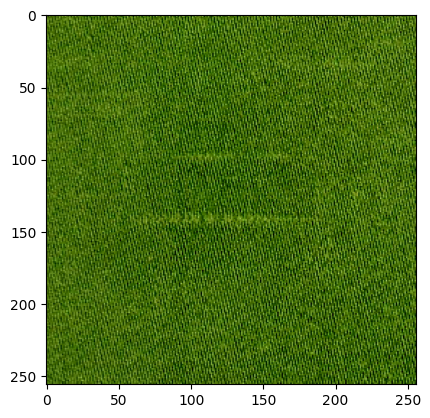

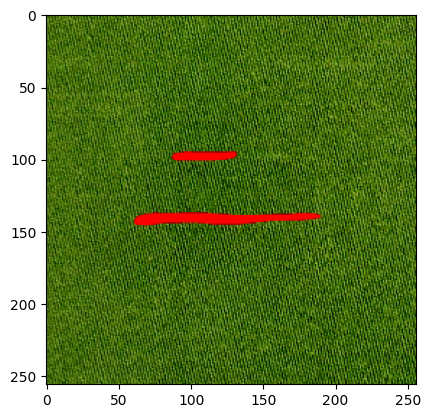

In [6]:
# import config
from torchvision.utils import save_image

both_transform = A.Compose(
    [A.Resize(width=256, height=256), A.HorizontalFlip(p=0.5)], additional_targets={"image0": "image"},
)

transform_only_input = A.Compose(
    [
        # A.ColorJitter(p=0.2),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        ToTensorV2(),
    ]
)

transform_only_mask = A.Compose(
    [
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        ToTensorV2(),
    ]
)
transform_for_input_image = A.Compose(
    [
        A.Resize(width=256, height=256),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        ToTensorV2(),
    ]
)

class MapDataset(Dataset):
    def __init__(self, root_dir, mask_dir):
        self.root_dir = root_dir
        self.mask_dir = mask_dir
        self.root_list_files = os.listdir(self.root_dir)

    def __len__(self):
        return len(self.root_list_files)

    def __getitem__(self, index):
        img_file1= self.root_list_files[index]
        selected_image = img_file1[:-3]+"tif"
        img_path1,img_path2 = os.path.join(self.root_dir, img_file1), os.path.join(self.mask_dir, selected_image)
        input_image, target_image = np.array(Image.open(img_path1)), np.array(Image.open(img_path2))
        # input_image = image[:, :600, :]
        # target_image = image[:, 600:, :]
        augmentations = both_transform(image=input_image, image0=target_image)
        input_image = augmentations["image"]
        target_image = augmentations["image0"]

        input_image = transform_only_input(image=input_image)["image"]
        target_image = transform_only_mask(image=target_image)["image"]

        return input_image, target_image

        # return image1,image2

dataset = MapDataset("/content/one-class-dataset-main/data/rawimage","/content/one-class-dataset-main/data/masks")
x,y = dataset[5]
print(x.shape,y.shape)
plt.imshow(x.permute(1,2,0))
plt.show()
plt.imshow(y.permute(1,2,0))
plt.show()

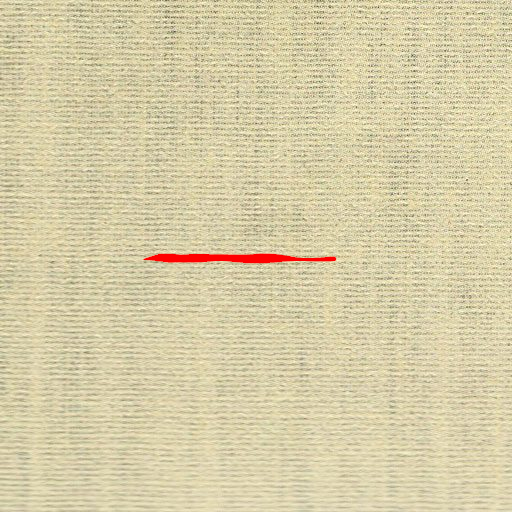

In [7]:
image = Image.open("/content/one-class-dataset-main/data/masks/0002.tif")
image

## Generator

In [8]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super(Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect")
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False, padding_mode="reflect")
            if down
            else nn.ConvTranspose2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )

        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        self.down = down

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x


class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        self.down1 = Block(features, features * 2, down=True, act="leaky", use_dropout=False)
        self.down2 = Block(
            features * 2, features * 4, down=True, act="leaky", use_dropout=False
        )
        self.down3 = Block(
            features * 4, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features * 8, features * 8, 4, 2, 1), nn.ReLU()
        )

        self.up1 = Block(features * 8, features * 8, down=False, act="relu", use_dropout=True)
        self.up2 = Block(
            features * 8 * 2, features * 4, down=False, act="relu", use_dropout=False
        )
        self.up3 = Block(
            features * 4 * 2, features * 2, down=False, act="relu", use_dropout=False
        )
        self.up4 = Block(features * 2, features, down=False, act="relu", use_dropout=False)
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        bottleneck = self.bottleneck(d4)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d4], 1))
        up3 = self.up3(torch.cat([up2, d3], 1))
        up4 = self.up4(up3)
        return self.final_up(up4)

def test():
    x = torch.randn((1, 3, 256, 256))
    model = Generator(in_channels=3, features=64)
    preds = model(x)
    print(model)
    print(preds.shape)

test()


Generator(
  (initial_down): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (down1): Block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
      (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=reflect)
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.2)
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (down2): Block(
    (conv): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
      (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=reflect)
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [9]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super(Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect")
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )

        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        self.down = down

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x


class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        self.down1 = Block(features, features * 2, down=True, act="leaky", use_dropout=False)
        self.down2 = Block(
            features * 2, features * 4, down=True, act="leaky", use_dropout=False
        )
        self.down3 = Block(
            features * 4, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down4 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down5 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down6 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features * 8, features * 8, 4, 2, 1), nn.ReLU()
        )

        self.up1 = Block(features * 8, features * 8, down=False, act="relu", use_dropout=True)
        self.up2 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up3 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up4 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=False
        )
        self.up5 = Block(
            features * 8 * 2, features * 4, down=False, act="relu", use_dropout=False
        )
        self.up6 = Block(
            features * 4 * 2, features * 2, down=False, act="relu", use_dropout=False
        )
        self.up7 = Block(features * 2 * 2, features, down=False, act="relu", use_dropout=False)
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features * 2, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], 1))
        up3 = self.up3(torch.cat([up2, d6], 1))
        up4 = self.up4(torch.cat([up3, d5], 1))
        up5 = self.up5(torch.cat([up4, d4], 1))
        up6 = self.up6(torch.cat([up5, d3], 1))
        up7 = self.up7(torch.cat([up6, d2], 1))
        return self.final_up(torch.cat([up7, d1], 1))


def test():
    x = torch.randn((1, 3, 256, 256))
    model = Generator(in_channels=3, features=64)
    preds = model(x)
    print(preds.shape)

test()

torch.Size([1, 3, 256, 256])


## Desciminator


In [10]:
import torch
import torch.nn as nn


class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(CNNBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, 4, stride, 1, bias=False, padding_mode="reflect"
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.conv(x)


class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels * 2,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                CNNBlock(in_channels, feature, stride=1 if feature == features[-1] else 2),
            )
            in_channels = feature

        layers.append(
            nn.Conv2d(
                in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"
            ),
        )

        self.model = nn.Sequential(*layers)

    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        x = self.initial(x)
        x = self.model(x)
        return x


def test():
    x = torch.randn((1, 3, 256, 256))
    y = torch.randn((1, 3, 256, 256))
    model = Discriminator(in_channels=3)
    preds = model(x, y)
    print(model)
    print(preds.shape)


test()

Discriminator(
  (initial): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (model): Sequential(
    (0): CNNBlock(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (1): CNNBlock(
      (conv): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (2): CNNBlock(
      (conv): Sequential(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=reflect)
        (1): Batc

['Fabric19.jpg', 'Fabric12.jpg', 'Fabric6.jpg', 'Fabric23.jpg', 'Fabric21.jpg', 'Fabric10.jpg', 'Fabric4.jpg', 'Fabric14.jpg', 'Fabric5.jpg', 'Fabric3.jpg', 'Fabric7.jpg', 'Fabric17.jpg', 'Fabric15.jpg', 'Fabric13.jpg', 'Fabric16.jpg', 'Fabric22.jpg', 'Fabric8.jpg', 'Fabric20.jpg']


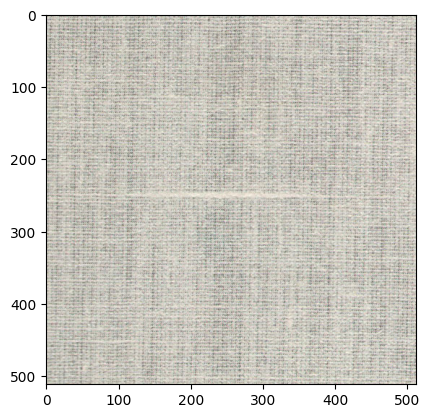

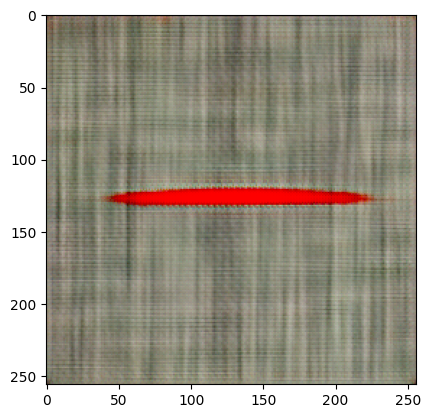

100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


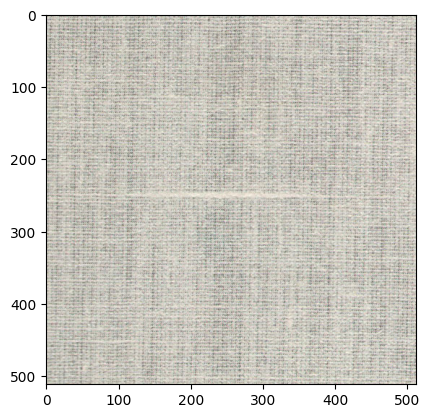

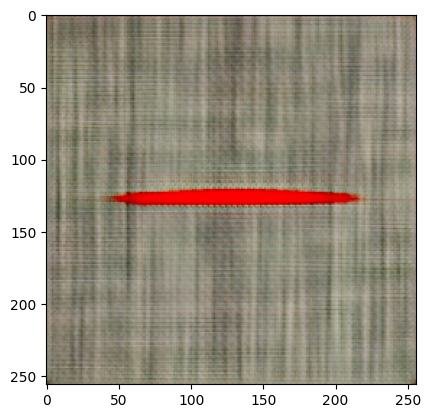

100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


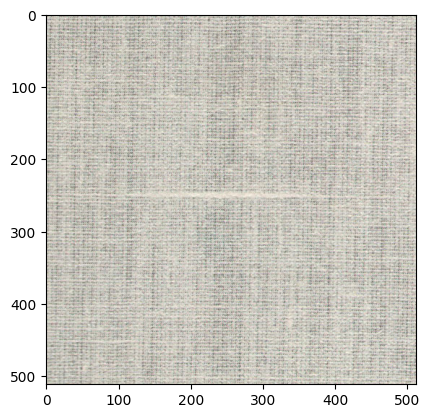

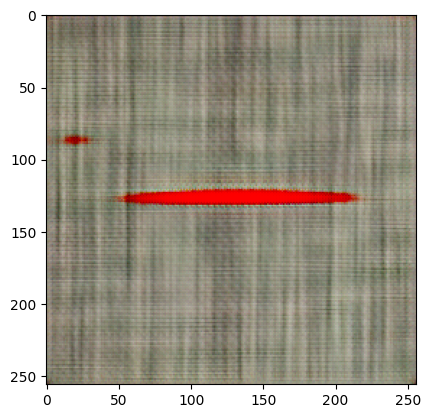

100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


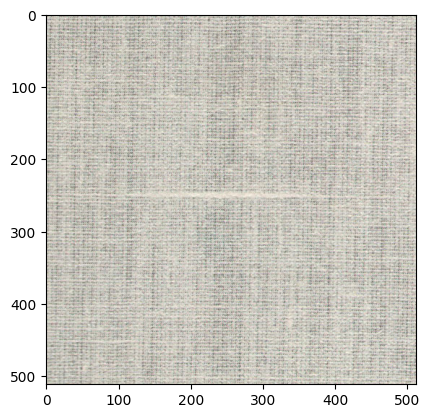

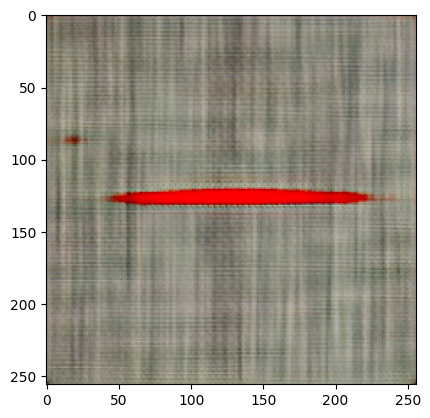

100%|██████████| 10/10 [00:05<00:00,  1.67it/s]


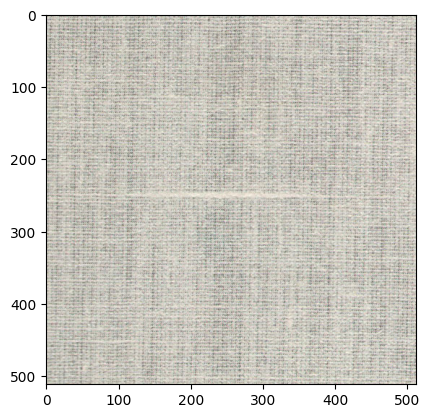

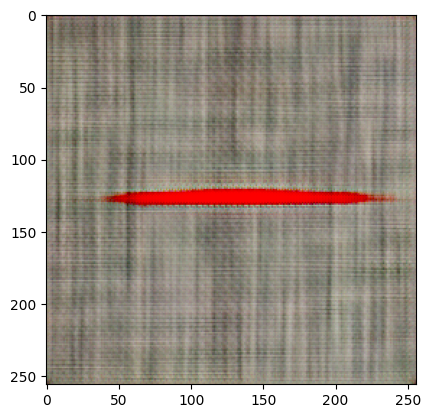

100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


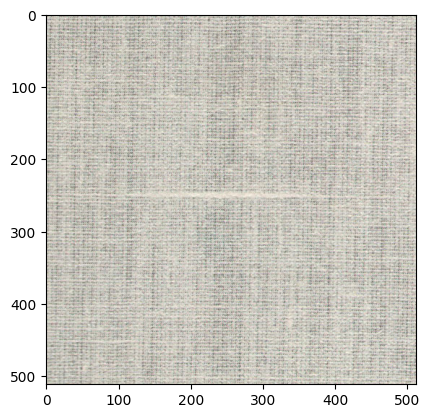

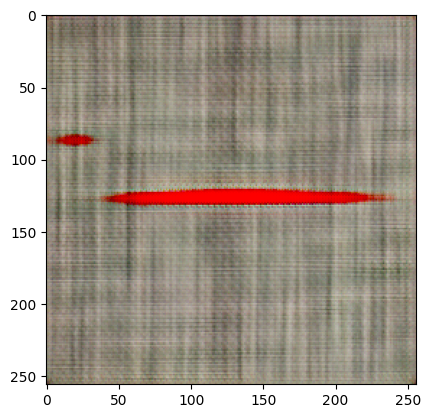

100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


In [ ]:
import pickle
NUM_EPOCHS = 101
def train_fn(disc, gen, loader, opt_disc, opt_gen, l1_loss, bce, epoch):
    gen.train()
    loop = tqdm(loader, leave=True)
    for idx, (x, y) in enumerate(loop):
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        # Train Discriminator
        y_fake = gen(x)
        D_real = disc(x, y)
        D_real_loss = bce(D_real, torch.ones_like(D_real))
        D_fake = disc(x, y_fake.detach())
        D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
        D_loss = (D_real_loss + D_fake_loss) / 2

        opt_disc.zero_grad()
        D_loss.backward()
        opt_disc.step()

        # Train generator
        D_fake = disc(x, y_fake)
        G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
        L1 = l1_loss(y_fake, y) * L1_LAMBDA
        G_loss = G_fake_loss + L1

        opt_gen.zero_grad()
        G_loss.backward()
        opt_gen.step()
        # save_image(y_fake, "img_grid.png", nrow=8)
        # img = Image.open("img_grid.png")
        # plt.imshow(img)
        # plt.show()

def main():
    root_dir = "/content/drive/MyDrive/Pytorch/Task4"
    root_list_files = os.listdir(root_dir)
    print(root_list_files)
    image = np.array(Image.open("Fabric1.jpg"))
    image = transform_for_input_image(image=image)["image"]
    image = image.unsqueeze(0)
    for root in root_list_files:
      img = np.array(Image.open(root))
      img = transform_for_input_image(image=img)["image"]
      img = img.unsqueeze(0)
      image = torch.cat([image,img],dim = 0)
    save_image(image, "img_grid_real.png", nrow=5)

    # disc = Discriminator(in_channels=3).to(DEVICE)
    # gen = Generator(in_channels=3, features=64).to(DEVICE)
    gen = pickle.load(open('gen_100.pkl','rb')) # loading model.pkl file
    disc = pickle.load(open('disc_100.pkl','rb')) # loading model.pkl file
    opt_disc = torch.optim.Adam(disc.parameters(), lr=LEARNING_RATE*0.1, betas=(0.5, 0.999))
    opt_gen = torch.optim.Adam(gen.parameters(), lr=LEARNING_RATE*0.1, betas=(0.5, 0.999))
    BCE = nn.BCEWithLogitsLoss()
    L1_LOSS = nn.L1Loss()

    train_dataset = MapDataset("/content/one-class-dataset-main/data/rawimage","/content/one-class-dataset-main/data/masks")
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
    )
    gen.train()
    disc.train()
    for epoch in range(NUM_EPOCHS):
        if epoch % 20 ==0:
          gen.eval()
          #
          with torch.inference_mode():
            image = image.to(DEVICE)
            out = gen(image)
            save_image(out, f"img_grid_{epoch}.png", nrow=5)
          #
          with torch.inference_mode():
            x = np.array(Image.open("/content/Fabric1.jpg"))
            # y = np.array(Image.open("/content/one-class-dataset-main/data/masks/0002.tif"))
            plt.imshow(x)
            plt.show()
            x = transform_for_input_image(image=x)["image"]
            # y = transform_for_input_image(image=y)["image"]
            x = x.unsqueeze(0).to(DEVICE)
            # y = y.unsqueeze(0).to(DEVICE)
            out = gen(x)
            plt.imshow(out.squeeze().permute(1,2,0).detach().cpu().numpy())
            plt.show()
          gen.train()
          pickle.dump(gen, open(f'gen_{epoch}.pkl','wb')) # make model.pkl file
          pickle.dump(disc, open(f'disc_{epoch}.pkl','wb')) # make model.pkl file
        train_fn(disc, gen, train_loader, opt_disc, opt_gen, L1_LOSS, BCE, epoch)

main()

# After this is the different version of training and other stuff so no need to go there if not needed...



In [ ]:
# def train_fn(disc, gen, loader, opt_disc, opt_gen, l1_loss, bce, epoch):
#     gen.train()
#     loop = tqdm(loader, leave=True)
#     for idx, (x, y) in enumerate(loop):
#         x = x.to(DEVICE)
#         y = y.to(DEVICE)

#         # Train Discriminator
#         y_fake = gen(x)
#         D_real = disc(x, y)
#         D_real_loss = bce(D_real, torch.ones_like(D_real))
#         D_fake = disc(x, y_fake.detach())
#         D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
#         D_loss = (D_real_loss + D_fake_loss) / 2

#         opt_disc.zero_grad()
#         D_loss.backward()
#         opt_disc.step()

#         # Train generator
#         D_fake = disc(x, y_fake)
#         G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
#         L1 = l1_loss(y_fake, y) * L1_LAMBDA
#         G_loss = G_fake_loss + L1

#         opt_gen.zero_grad()
#         G_loss.backward()
#         opt_gen.step()

#         if idx  == 5:
#           print("hii")


# def main():
#     disc = Discriminator(in_channels=3).to(DEVICE)
#     gen = Generator(in_channels=3, features=64).to(DEVICE)
#     opt_disc = torch.optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999),)
#     opt_gen = torch.optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
#     bce = nn.BCEWithLogitsLoss()
#     l1_loss = nn.L1Loss()

#     train_dataset = MapDataset("/content/one-class-dataset-main/data/rawimage","/content/one-class-dataset-main/data/masks")
#     train_loader = DataLoader(
#         train_dataset,
#         batch_size=BATCH_SIZE,
#         shuffle=True,
#         num_workers=NUM_WORKERS,
#     )
#     x = np.array(Image.open("/content/one-class-dataset-main/data/rawimage/0002.jpg"))
#     y = np.array(Image.open("/content/one-class-dataset-main/data/masks/0002.tif"))
#     plt.imshow(y)
#     plt.show()
#     x = transform_for_input_image(image=x)["image"]
#     y = transform_for_input_image(image=y)["image"]
#     x = x.unsqueeze(0).to(DEVICE)
#     y = y.unsqueeze(0).to(DEVICE)
#     for epoch in range(1000):
#         # Train Discriminator
#         y_fake = gen(x)
#         D_real = disc(x, y)
#         D_real_loss = bce(D_real, torch.ones_like(D_real))
#         D_fake = disc(x, y_fake.detach())
#         D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
#         D_loss = (D_real_loss + D_fake_loss) / 2

#         opt_disc.zero_grad()
#         D_loss.backward()
#         opt_disc.step()

#         # Train generator
#         D_fake = disc(x, y_fake)
#         G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
#         L1 = l1_loss(y_fake, y) * L1_LAMBDA
#         G_loss = G_fake_loss + L1

#         opt_gen.zero_grad()
#         G_loss.backward()
#         opt_gen.step()

#         if epoch%99 == 0:
#           out = gen(x)
#           plt.imshow(out.squeeze().permute(1,2,0).detach().cpu().numpy())
#           plt.show()


# main()

In [ ]:
# !cp /content/drive/MyDrive/Pytorch/gen_100.pkl .
# !cp /content/drive/MyDrive/Pytorch/disc_100.pkl .
# !cp /content/drive/MyDrive/Pytorch/disc_200.pkl .
# !cp /content/drive/MyDrive/Pytorch/disc_120.pkl .

cp: cannot stat '/content/drive/MyDrive/Pytorch/gen_100.pkl': No such file or directory
cp: cannot stat '/content/drive/MyDrive/Pytorch/disc_100.pkl': No such file or directory


In [11]:
!cp gen_100.pkl /content/drive/MyDrive/Pytorch
!cp disc_100.pkl /content/drive/MyDrive/Pytorch

cp: cannot stat 'gen_100.pkl': No such file or directory
cp: cannot stat 'disc_100.pkl': No such file or directory


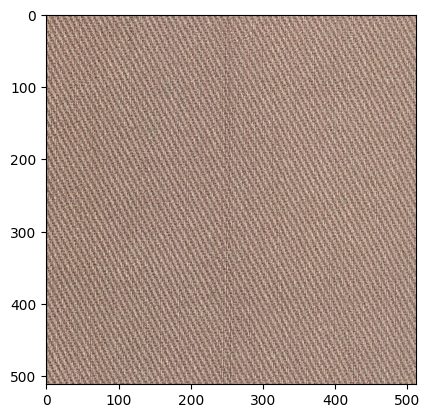

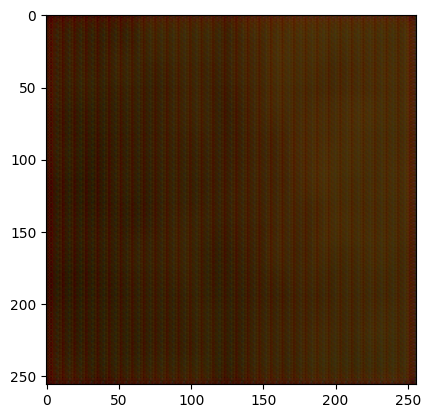

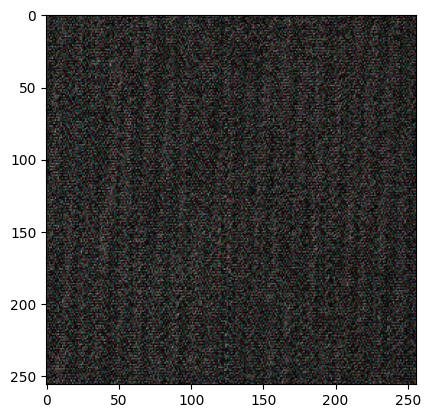

In [ ]:
import pickle
gen1 = pickle.load(open("gen_200.pkl","rb"))
x = np.array(Image.open("/content/Fabric5.jpg"))
plt.imshow(x)
plt.show()
x = transform_for_input_image(image=x)["image"]
x = x.unsqueeze(0).to(DEVICE)
gen1.eval()
with torch.inference_mode():
  out = gen1(x)
  plt.imshow(out.squeeze().permute(1,2,0).detach().cpu().numpy())
  plt.show()
  plt.imshow(abs(out.squeeze().permute(1,2,0).detach().cpu()-x.squeeze().permute(1,2,0).cpu()).numpy())
  plt.show()


In [ ]:
print(np.mean(val))
print(val.shape)
plt.imshow(val >= np.mean(val))
plt.show()

In [ ]:
gen1_cpu = gen2.to("cpu")
epoch = 120
gen1_cpu.state_dict()

In [ ]:
pickle.dump(gen1_cpu, open(f'gen_{epoch}_cpu.pkl','wb')) # make model.pkl file


In [ ]:
x =np.array(Image.open("/content/one-class-dataset-main/data/masks/0005.tif"))
out =  np.array(Image.open("/content/one-class-dataset-main/data/rawimage/0005.jpg"))
# plt.imshow(abs(x-out)*abs(x-out)>=0.0001)
# plt.show()
np.array(abs(x-out)>=0.1)

array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False,

In [ ]:
!cp /content/drive/MyDrive/Pytorch/gen_200.pkl .

### outputs



In [ ]:
import pickle
root_dir = "/content/drive/MyDrive/Pytorch/Task4"
root_list_files = os.listdir(root_dir)
print(root_list_files)
im = np.array(Image.open(f"/content/drive/MyDrive/Pytorch/Task4/Fabric1.jpg"))
im = transform_for_input_image(image=im)["image"]
im = im.unsqueeze(0).to(DEVICE)
image = np.array(Image.open(root_dir+"/"+"Fabric1.jpg"))
image = transform_for_input_image(image=image)["image"]
image = image.unsqueeze(0)
for root in root_list_files:
  img = np.array(Image.open(root_dir+"/"+root))
  img = transform_for_input_image(image=img)["image"]
  img = img.unsqueeze(0)
  image = torch.cat([image,img],dim = 0)
print(image.shape)
m = nn.Threshold(0.35, 0)
gen2 = pickle.load(open("gen_200.pkl","rb"))
x = np.array(Image.open("/content/Fabric20.jpg"))
plt.imshow(x)
plt.show()
x = transform_for_input_image(image=x)["image"]
x = x.unsqueeze(0).to(DEVICE)
with torch.inference_mode():
  image = image.to(DEVICE)
  save_image(image, "img_grid_real.png", nrow=5)
  out = gen2(image)
  save_image(out, "img_grid.png", nrow=5)

In [ ]:
conv = torch.nn.Conv2d(3,3,3,1,1,bias = False)
conv.weight.data.fill_(1)
image = conv(torch.from_numpy(val).permute(2,0,1).unsqueeze(0))
plt.imshow(image.squeeze().permute(1,2,0).detach().numpy()/7)
